In [1]:
# %pip install geopandas seaborn google-streetview folium branca
# %pip install openpyxl


import os, os.path
#import ogr, osr
import time
import sys
import json

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import urllib
import fiona
import google_streetview.api

from PIL import Image
from matplotlib import pyplot as plt
import requests
import io

import folium
import branca.colormap


import sys, platform
print("=== Environment Info ===")
print(f"Python envi    : {sys.executable}")
print(f"Python version : {sys.version.split()[0]}")
print(f"Platform       : {platform.platform()}")
print(f"geopandas      : {gpd.__version__}")
print(f"numpy          : {np.__version__}")
print(f"matplotlib     : {plt.matplotlib.__version__}")
print("========================")

=== Environment Info ===
Python envi    : c:\Users\pc\.conda\envs\geo_env\python.exe
Python version : 3.11.13
Platform       : Windows-10-10.0.22631-SP0
geopandas      : 0.14.4
numpy          : 2.2.6
matplotlib     : 3.10.6


# Data Path

In [2]:
from pathlib import Path
print(Path.cwd())


dir_main = Path(r"G:\Shared drives\Wellcome Trust Project Data")
dir_um   = dir_main / "0_source_data/Geolocation Data"
dir_code = Path.cwd().parent; print(dir_code)


## This is where you want your meta data and Google Street View images output to

dir_meta   = dir_main / '1_preprocess/UM_GVI/1_metadata_um' ## the metadata text files from the previous step
dir_gsv    = dir_main / '1_preprocess/UM_GVI/2_gsvimgs_um'
dir_output = dir_main / '1_preprocess/UM_GVI/3_greenViewIndex'

dir_meta.mkdir(parents=True, exist_ok=True)
dir_gsv.mkdir(parents=True, exist_ok=True)
dir_output.mkdir(parents=True, exist_ok=True)

d:\natcap\urban-cooling-health\code\Yougeng-extreme-heat_nature_mental-health
d:\natcap\urban-cooling-health\code


## Import UrbanMind data

In [24]:
UM = pd.read_excel(dir_um / "UM_extract_04July24_UPDATE[13.12.24].xlsx") #import your own UM data from your local path
# UM.head()
# rows, columns
print('Original UM shape:', UM.shape)            # e.g., (n_rows, n_cols)


# filter to only outdoors -------------------------------
UM_filter = UM[UM['in_out'] == 'Outdoors']
# Display the filtered DataFrame
# UM_filter.head()
# rows, columns
print('Filtered UM shape:', UM_filter.shape)            # e.g., (n_rows, n_cols)

# # handy summary incl. non-nulls & dtypes
# UM_filter.info()

Original UM shape: (17645, 71)
Filtered UM shape: (3379, 71)


## Take a random 100 rows as data sample

In [ ]:
# exactly 100 random rows
um_sampled = UM_filter.sample(n=10, random_state=42)   # set random_state for reproducibility
print(um_sampled.shape)  

(10, 71)


## Access GoogleStreetView images based on GPS

In [ ]:
# decide the data input 
um_input = um_sampled

# only keep the user id, EMA id, latitude and longtitude of GPS point for the first user
c = um_input.reset_index(drop=True)[['newid','obsid','latitude','longitude']].values.tolist() # Yougeng's original code
# c = um_input.reset_index(drop=True)[['newid','date','latitude','longitude']].values.tolist()  # use 'date' instead of 'obsid' to match the metadata in the output
# print(c)


In [ ]:
## Load API and set up parameters

# %pip install python-dotenv

from dotenv import load_dotenv
import os
load_dotenv(dotenv_path=dir_code / "google_api_key.env")  # by default loads .env from CWD

api_key = os.getenv("GOOGLE_API_KEY")
assert api_key, "Missing GOOGLE_API_KEY"


key=api_key # here insert your own Google API
num=5       # the batch size, originally 500


featureNum = len(c) 
batch = int(featureNum/num + 0.5)
number = 0 

## Download metadata

In [8]:
## we will get the nearest GSV image based on the coordinate we input
for b in range(batch):
    # for each batch process num GSV site
    start = b*num
    end = (b+1)*num
    if end > featureNum:
        end = featureNum
    
    ouputTextFile = 'Pnt_start%s_end%s.txt'%(start,end)
    ouputGSVinfoFile = os.path.join(dir_meta, ouputTextFile)
    
    if os.path.exists(ouputGSVinfoFile):
        continue

    time.sleep(1)
    
    with open(ouputGSVinfoFile, 'w') as panoInfoText:
                
        for i in c:
            user_id = i[0]
            assessment_time = i[1]
            lat = i[2]
            lon = i[3]
            # print(user_id, assessment_time, lat, lon)

            urlAddress = r'https://maps.googleapis.com/maps/api/streetview/metadata?size=600x300&location=%s,%s&heading=-45&pitch=42&fov=110&source=outdoor&key=%s'%(lat, lon, key)
            time.sleep(0.1)
            if sys.version_info[0] == 2:
                # from urllib2 import urlopen
                import urllib
                metaData = urllib.urlopen(urlAddress).read()

            if sys.version_info[0] == 3:
                import urllib.request
                request = urllib.request.Request(urlAddress)
                metaData = urllib.request.urlopen(request).read()

            data = json.loads(metaData)
            
            if data['status'] == 'NOT_FOUND': 
                print('The data is not existing')
                continue
            
            if data['status'] == 'ZERO_RESULTS': 
                print('The data is not existing')
                continue

            # print('data fields:', list(data.keys())) # check the available fields

            panoDate = data['date']
            panoId = data['pano_id']
            panoLat = data['location']['lat']
            panoLon = data['location']['lng']
            number = number + 1

            print ('Num: %s/%s, User ID: %s, assessment time: %s, the coordinate (%s,%s), panoId is: %s, panoDate is: %s'%(number, featureNum, user_id, assessment_time, panoLat,panoLon,panoId, panoDate))
            lineTxt = 'userID: %s assessment: %s panoID: %s panoDate: %s longitude: %s latitude: %s\n'%(user_id, assessment_time, panoId, panoDate, panoLon, panoLat)
            panoInfoText.write(lineTxt)
            
    panoInfoText.close()

## Download GSV image and Calculate GVI

In [9]:
processed_pano_ids = set()

# list all the metadata and then get the lon, lat, date info to download the GSV images to your google drive
for txt in os.listdir(dir_meta):
  txtfile = os.path.join(dir_meta, txt)

  lines = open(txtfile,"r")
  pitch = 0

  # loop all lines in the txt files
  for idx,line in enumerate(lines):
      metadata = line.split(" ")
#      userID = metadata[1]
#      assessment = metadata[3]
      panoID = metadata[5]
      panoDate = metadata[7]
      month = panoDate[-2:]
      lon = metadata[9]
      lat = metadata[11][:-1]

      # print('The lon, lat are:', lon, lat)

      if panoID in processed_pano_ids:
          print(f"Skipping panoID {panoID} as it has already been processed.")
          continue

    # Add the panoID to the set
      processed_pano_ids.add(panoID)

      headingArr = 360/6*np.array([0,1,2,3,4,5])

      # calculate the green view index
      greenPercent = 0.0

      for heading in headingArr:
          # print ("Heading is: ",heading)

          # the name of the output image
          imgName = r'%s - %s - %s - %s - %s.jpg'%(panoID, lon, lat, panoDate, heading)
          mergedImgFile = os.path.join(dir_gsv, imgName)
          if os.path.exists(mergedImgFile): continue

          # using different keys for different process, each key can only request 25,000 imgs every 24 hours
          URL = "http://maps.googleapis.com/maps/api/streetview?size=400x400&pano=%s&fov=60&heading=%d&pitch=%d&sensor=false&key=%s"%(panoID, heading, pitch, key)
          # let the code to pause by 1s, in order to not go over data limitation of Google quota
          time.sleep(1)

          response = requests.get(URL)
          im = np.array(Image.open(io.BytesIO(response.content)))

          img = Image.fromarray(im)
          img.save(mergedImgFile)

Skipping panoID z-vd9k6DDnU6zzYWrHm0NA as it has already been processed.
Skipping panoID lzMa95Mh8-nmkipj8EatGQ as it has already been processed.
Skipping panoID fl3VSTRVAaxHr-McctyshQ as it has already been processed.
Skipping panoID k1HE-Wqv7_i58kNfKS_XnA as it has already been processed.
Skipping panoID o4dlBthWecsQTJhzf6Pc3w as it has already been processed.
Skipping panoID eduCDouZvfSJN4f37I2I9A as it has already been processed.
Skipping panoID IHtfFvHPmePxO8SwCAGrEQ as it has already been processed.
Skipping panoID p_MLjruLILqpWxEHOnhfZg as it has already been processed.


# Semantic segmentation and Generate the Green View Index 

In [10]:
# %pip show keras
# %pip install keras
# %pip install opencv-python
# %pip install tensorflow
# %pip install tensorflow-hub

In [ ]:
import cv2
import zipfile
import glob as glob
 
import tensorflow as tf
import tensorflow_hub as hub

from matplotlib.patches import Rectangle
 
import warnings
import logging
import absl
 
# Filter absl warnings
warnings.filterwarnings("ignore", module="absl")
 
# Capture all warnings in the logging system
logging.captureWarnings(True)
 
# Set the absl logger level to 'error' to suppress warnings
absl_logger = logging.getLogger("absl")
absl_logger.setLevel(logging.ERROR)
 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


## Load the pre-trained model from TensorFlow Hub
model1 = hub.load('https://kaggle.com/models/google/hrnet/frameworks/TensorFlow2/variations/v2-w48/versions/1')

In [ ]:
def preprocess_image(image_path, target_size=(512, 512)):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize and normalize the image
    resized_image = cv2.resize(image, target_size)
    normalized_image = resized_image / 255.0  # Normalize to [0, 1]
    input_tensor = np.expand_dims(normalized_image, axis=0)  # Add batch dimension
    return image, input_tensor


def calculate_percentage(mask, total_pixels):
    vegetation_pixels = np.sum(mask == 255)
    percentage = (vegetation_pixels / total_pixels) * 100
    return percentage

In [15]:
## This is where you want your meta data and Google Street View images output to
# root = 'D:/NatCap Research/Wellcome Trust/Output'
# indir= os.path.join(root, 'metadata2')
# outdir = os.path.join(root, 'gsvimgs2')


# save the green view index results in a new text file
GreenViewTxtFile = os.path.join(dir_output, 'greenviewIndex.txt')

# Create file if it does not exist
if not os.path.exists(GreenViewTxtFile):
    with open(GreenViewTxtFile, 'w') as f:
        pass  # creates an empty file

In [16]:


# list all the metadata and then get the lon, lat, date info to download the GSV images to your google drive
for txt in os.listdir(dir_meta):
    txtfile = os.path.join(dir_meta, txt)
    lines = open(txtfile,"r")
    pitch = 0
    
    with open(GreenViewTxtFile,"w") as gvResTxt:
    # loop all lines in the txt files
        for idx,line in enumerate(lines):
            metadata = line.split(" ")
            userID = metadata[1]
            assessment = metadata[3]
            panoID = metadata[5]
            panoDate = metadata[7]
            month = panoDate[-2:]
            lon = metadata[9]
            lat = metadata[11][:-1]
            # print('The lon, lat are:', lon, lat)

            headingArr = 360/6*np.array([0,1,2,3,4,5])

            # calculate the green view index based on downloaded images 
            greenPercent = 0.0

            for heading in headingArr:
                # print ("Heading is: ",heading)

                imgName = r'%s - %s - %s - %s - %s.jpg'%(panoID, lon, lat, panoDate, heading)
                mergedImgFile = os.path.join(dir_gsv, imgName)

                original_image, input_tensor = preprocess_image(mergedImgFile)
                output = model1(input_tensor)  # The output shape will be [1, height, width, num_classes]
                segmentation_map = tf.argmax(output, axis=-1).numpy()[0]  # Convert to class labels
    
                tree_mask = (segmentation_map == 9).astype(np.uint8) * 255
                grass_mask = (segmentation_map == 10).astype(np.uint8) * 255
                
                total_pixels = original_image.shape[0] * original_image.shape[1]
                tree_percentage = calculate_percentage(tree_mask, total_pixels)
                grass_percentage = calculate_percentage(grass_mask, total_pixels)
                vegetation_percentage = tree_percentage+grass_percentage
                greenPercent = greenPercent + vegetation_percentage

            greenview = greenPercent/6.0
            print('The green view index is:', greenview)

            lineTxt = 'userID: %s obsID: %s panoID: %s panoDate: %s longitude: %s latitude: %s greenview: %s\n'%(userID, assessment, panoID, panoDate, lon, lat, greenview)
            gvResTxt.write(lineTxt)

The green view index is: 9.852916666666667
The green view index is: 29.300520833333326
The green view index is: 29.97125
The green view index is: 0.3680208333333333
The green view index is: 3.881979166666666
The green view index is: 67.83114583333334
The green view index is: 24.18635416666667
The green view index is: 9.219375
The green view index is: 9.852916666666667
The green view index is: 29.300520833333326
The green view index is: 29.97125
The green view index is: 0.3680208333333333
The green view index is: 3.881979166666666
The green view index is: 67.83114583333334
The green view index is: 24.18635416666667
The green view index is: 9.219375


## save GVI index to dataframe and CSV

In [17]:

# lines = open(GreenViewTxtFile,"r")
# newidList = []
# obsidList = []
# panoIdList = []
# panoDateList = []
# panoLonList = []
# panoLatList = []
# greenViewList = []

# for line in lines:
#     elem = line.split(' ')
#     newidList.append(elem[1])
#     obsidList.append(elem[3])
#     panoIdList.append(elem[5])
#     panoDateList.append(elem[7])
#     panoLonList.append(elem[9])
#     panoLatList.append(elem[11])
#     greenViewList.append(elem[13][:-2])


# ## generate a dataframe with user_ID, EMA ID, panoID for GSV, data when GSV was taken, latitude, longitude, and GVI
# GVI = pd.DataFrame({'newid': newidList, 'obsid': obsidList, 'panoId': panoIdList, 'panoDate': panoDateList, 'panoLon': panoLonList, 
#                    'panoLat': panoLatList, 'GVI': greenViewList})

# # GVI.head()

# ## save the GVI results in a csv file
# f = outdir / 'pnt_greenViewIndex_table.csv'
# GVI.to_csv(f, index=False)



import re
csv_path = GreenViewTxtFile.replace(".txt", ".csv")
rows = []
# read line by line
with open(GreenViewTxtFile, "r", encoding="utf-8") as f:
    for line in f:
        # find all key:value pairs
        pairs = re.findall(r"(\S+?):\s*([^\s]+)", line)
        if pairs:
            row = {k: v for k, v in pairs}
            rows.append(row)

# make DataFrame
df = pd.DataFrame(rows)
# save to CSV
df.to_csv(csv_path, index=False)
print(f"Saved CSV → {csv_path}")

Saved CSV → G:\Shared drives\Wellcome Trust Project Data\1_preprocess\UM_GVI\3_greenViewIndex\greenviewIndex.csv


# Example plot

In [18]:
# image_path = r'D:\NatCap Research\Wellcome Trust\Output\gsvimgs2\_6xhPKvJq7EraoDtfEM5Zw - -4.547079109495603 - 50.83117052888723 - 2022-09 - 180.0.jpg' 
image_path = dir_gsv / 'lzMa95Mh8-nmkipj8EatGQ - -0.1900064842670443 - 51.45765500852751 - 2025-05 - 180.0.jpg' 

In [22]:
# Example usage
original_image, input_tensor = preprocess_image(image_path)


# Perform inference
output = model1(input_tensor)  # The output shape will be [1, height, width, num_classes]
segmentation_map = tf.argmax(output, axis=-1).numpy()[0]  # Convert to class labels

print("Segmentation map shape:", segmentation_map.shape)  # Should be (height, width)
print("Unique classes in segmentation map:", np.unique(segmentation_map))  # List of unique class labels

Segmentation map shape: (512, 512)
Unique classes in segmentation map: [ 1  2  3  5  6  8  9 11 14]


In [ ]:
def filter_vegetation(segmentation_map, vegetation_classes):
    mask = np.zeros_like(segmentation_map)
    for class_id in vegetation_classes:
        mask[segmentation_map == class_id] = class_id
    return mask


# Filter vegetation classes (Tree: 21, Terrain: 22)
vegetation_classes = [9, 10]
vegetation_mask = filter_vegetation(segmentation_map, vegetation_classes)

# Define colors for each class
class_colors = {
    9: [34, 139, 34],  # Forest green for trees
    10: [124, 252, 0]  # Lawn green for grass
}


def apply_color_map(segmentation_map, class_colors):
    height, width = segmentation_map.shape
    color_map = np.zeros((height, width, 3), dtype=np.uint8)
    for class_id, color in class_colors.items():
        color_map[segmentation_map == class_id] = color
    return color_map

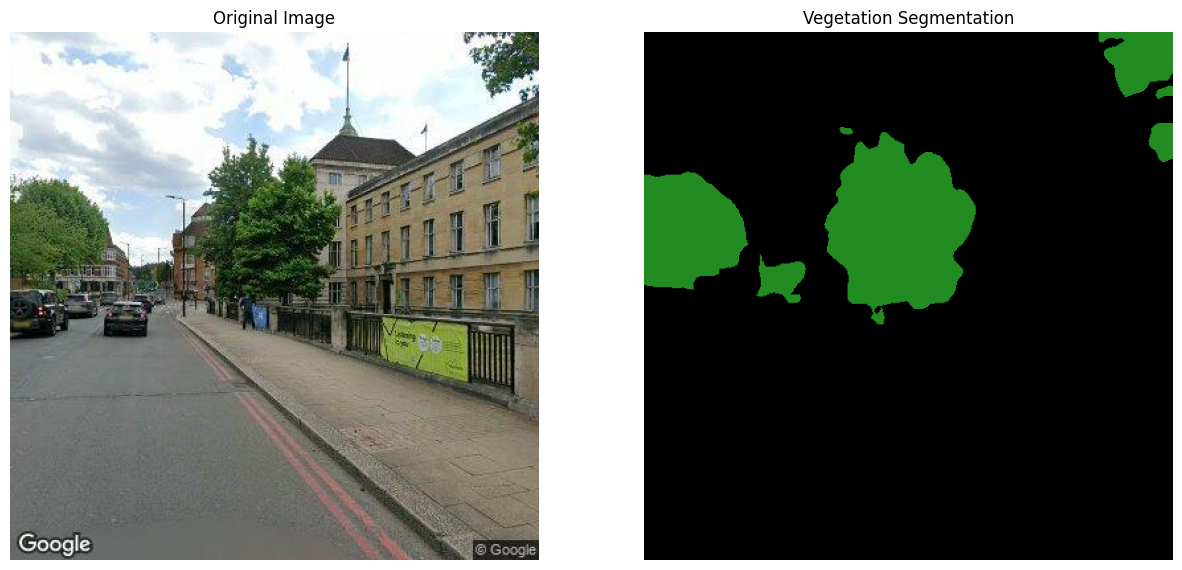

In [21]:
# Apply color map to the vegetation mask
colored_segmentation = apply_color_map(vegetation_mask, class_colors)

# Plot the original image and the segmentation mask
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Vegetation Segmentation")
plt.imshow(colored_segmentation)
plt.axis("off")

# --- Save figure before showing ---
outfile = dir_output / "segmentation_figure_example.png"
plt.savefig(outfile, dpi=300, bbox_inches="tight", transparent=True)

plt.show()